## Telluric changes during Observation Time




Testing the difference in the telluric spectra between the combination of individual telluric spectra taken during each nod cycle observation and a single spectra scaled to the average airmass of the nod cycle.

These calculations show there is a negligable difference between both of these senarios. Around 0.01-0.1% of the transmittance values or 0.02% of original spectra.

In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import fits
import TelluricSpectra.Obtain_Telluric as obt
%matplotlib inline

# Load in telluric line model 
TellPath = "/home/jneal/Phd/data/Tapas/"
Telluric_filenames = ["tapas_HD30501_1_R50000_2012-04-07T00:20:00.ipac", "tapas_HD30501_2a_R50000_2012-08-01T09:28:00.ipac", "tapas_HD30501_2b_R50000_2012-08-06T09:56:00.ipac", "tapas_HD30501_3_R50000_2012-08-02T09:01:00.ipac"]  

def airmass_scaling(spectra, spec_airmass, obs_airmass):
    """Scale the Telluric spectra to match the airmass of the observation"""
    B = obs_airmass / spec_airmass
    new_spec = spectra ** B
    return new_spec 

def do_change_calculations(CriresPath, crires_file, tapas_filename):
    
    tapas_data, tapas_hdr = obt.load_telluric(TellPath, tapas_filename)
    tapas_airmass = float(tapas_hdr["airmass"])
    print("HD30501-1")
    print("Telluric Airmass ", tapas_airmass)
    tapas_respower = int(float((tapas_hdr["respower"])))
    print("Telluric Resolution Power =", tapas_respower)
    
    Nod_airmass = []
    Nod_time = []
    with open(crires_file, "r") as f:
        for line in f:
            fname = line[:-1] + ".fits"
            #print(fname)
            hdr = fits.getheader(CriresPath + fname)
            datetime = hdr["DATE-OBS"]
            time = datetime[11:19]
            airmass_start = hdr["HIERARCH ESO TEL AIRM START"]
            airmass_end = hdr["HIERARCH ESO TEL AIRM END"]
            Nod_mean_airmass = round((airmass_start + airmass_end) / 2 , 4)
            #print("Observation time -", datetime, "time =", time)
            #print("Airmass start = {}, end = {}, Mean = {}".format(airmass_start, airmass_end, Nod_mean_airmass))
            Nod_airmass.append(Nod_mean_airmass)
            Nod_time.append(time)
        
        
    print("\nCRIRES Detector Intergration Time =", hdr["HIERARCH ESO DET DIT"])
    print("Nod_airmass ", Nod_airmass)
    print("Nod_time ", Nod_time)

    Average_airmass = np.mean(Nod_airmass)
    print("Average airmass", Average_airmass)
    
    scaled_tapas_data = np.empty((8,len(tapas_data[1])))
                      
    for j in range(8):
        obs_airmass = Nod_airmass[j]
        scaled_tapas_data[j] = np.array(airmass_scaling(tapas_data[1], tapas_airmass, obs_airmass))
    
    #print(scaled_tapas_data)

    average_airmass_tapas = airmass_scaling(tapas_data[1], tapas_airmass, Average_airmass)     

    # Adding and normalise the 8 nod telluric spectra
    Combined_tapas_data = np.sum(scaled_tapas_data, axis=0)/8
    #print(Combined_tapas_data)

    # Calculate Differences
    Tapas_difference = Combined_tapas_data - average_airmass_tapas
    first_last_diff = scaled_tapas_data[0] - scaled_tapas_data[7]
    
    # Plotting the results
    plt.figure()

    plt.plot(tapas_data[0], Tapas_difference)
    plt.title("Combined Tapas - Average Tapas")
    plt.xlabel("Wavelength(nm)")
    plt.ylabel("Transmittance Difference")
    plt.show()

    plt.figure()
    plt.plot(tapas_data[0], first_last_diff)
    plt.title("First Tapas - Last Tapas")
    plt.xlabel("Wavelength(nm)")
    plt.ylabel("Transmitance difference")
    plt.show()

    
    plt.figure()
    for jj in range(8):
        plt.plot(tapas_data[0], scaled_tapas_data[jj], label="spectra {}".format(jj))
    plt.show()

    # Percentage of absorbtion
    percentage_of_absorption = 100 * Tapas_difference / Combined_tapas_data
    
    plt.figure()
    plt.plot(tapas_data[0], percentage_of_absorption)
    plt.title("Percentage of transmittance difference")
    plt.ylabel("%")
    plt.xlabel("Wavelength (nm)")
    plt.show()

    
    #  Historgrams of differences
    plt.subplot(121)
    plt.hist(scaled_tapas_data[0]-scaled_tapas_data[7])
    plt.title("Difference between\nfirst and last observation")
    #plt.show()
    plt.subplot(122)
    plt.hist(Tapas_difference)
    plt.title("Difference between\ncombined and the average")
    plt.show()


    print("Maximum transmittance difference between combined and averaged", max(Tapas_difference))
    print("Maximum percentage change between combined and averaged = {} %".format(max(percentage_of_absorption)))
    print("Maximum difference between first and last telluric spectra", max(first_last_diff))
    

## HD30501-1 

HD30501-1
Telluric Airmass  1.605025
Telluric Resolution Power = 50000

CRIRES Detector Intergration Time = 180.0
Nod_airmass  [1.5525, 1.5715, 1.59, 1.6105, 1.631, 1.6525, 1.6745, 1.6975]
Nod_time  ['00:08:29', '00:12:08', '00:15:38', '00:19:19', '00:22:48', '00:26:28', '00:29:57', '00:33:37']
Average airmass 1.6225


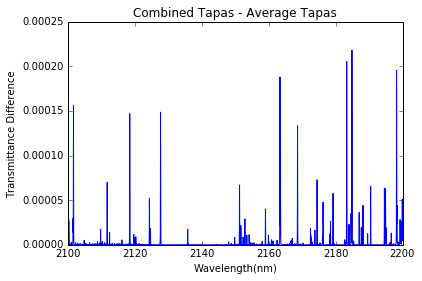

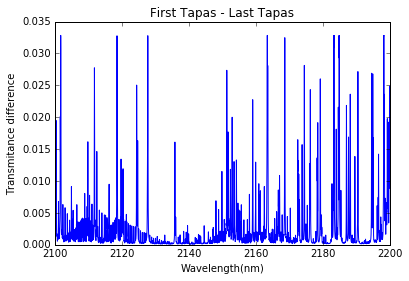

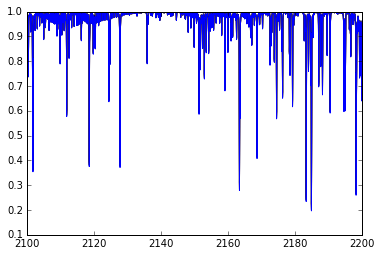

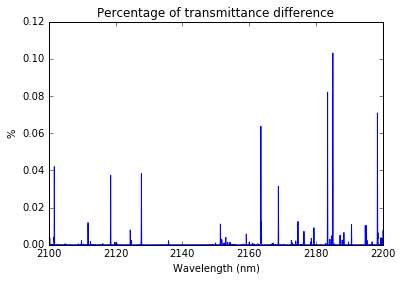

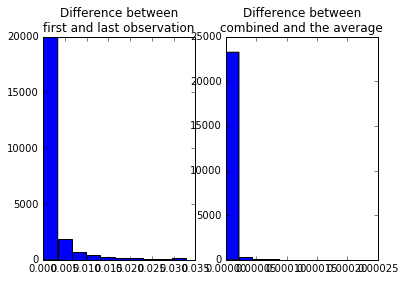

Maximum transmittance difference between combined and averaged 0.000218019902459
Maximum percentage change between combined and averaged = 0.1031213027161641 %
Maximum difference between first and last telluric spectra 0.0328364049999


In [9]:
HD30501_1_files = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-1/list_spectra.txt"
HD30501_1_Path = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-1/Raw_files/"
HD30501_1_tapas = "/tapas_HD30501_1_R50000_2012-04-07T00:20:00.ipac"

do_change_calculations(HD30501_1_Path, HD30501_1_files, HD30501_1_tapas)



## HD30501-2a

HD30501-1
Telluric Airmass  1.429577
Telluric Resolution Power = 50000

CRIRES Detector Intergration Time = 180.0
Nod_airmass  [1.4665, 1.451, 1.437, 1.4225, 1.409, 1.396, 1.383, 1.3705]
Nod_time  ['09:17:30', '09:21:08', '09:24:37', '09:28:17', '09:31:46', '09:35:21', '09:38:50', '09:42:30']
Average airmass 1.4169375


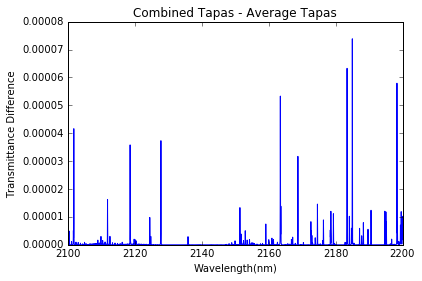

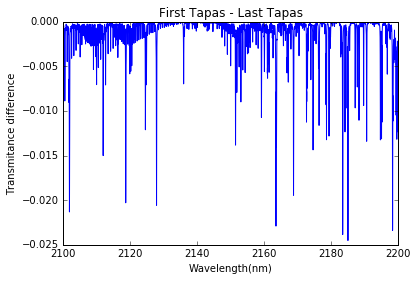

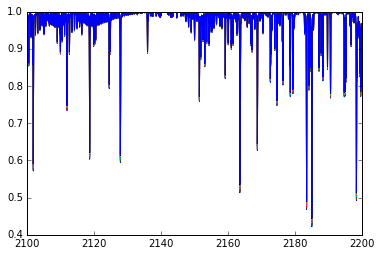

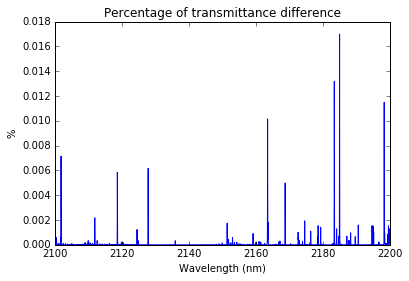

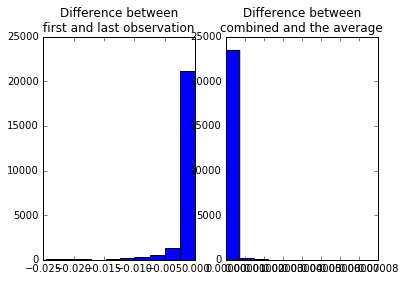

Maximum transmittance difference between combined and averaged 7.38363644631e-05
Maximum percentage change between combined and averaged = 0.016991175790397724 %
Maximum difference between first and last telluric spectra -5.44111885208e-05


In [10]:
# Filenames

HD30501_2a_files = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-2a/list_spectra.txt"
HD30501_2a_Path = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-2a/Raw_files/"
HD30501_2a_tapas = "/tapas_HD30501_2a_R50000_2012-08-01T09:28:00.ipac"

do_change_calculations(HD30501_2a_Path, HD30501_2a_files, HD30501_2a_tapas)

## HD30501-2b

HD30501-1
Telluric Airmass  1.276453
Telluric Resolution Power = 50000

CRIRES Detector Intergration Time = 180.0
Nod_airmass  [1.3105, 1.3005, 1.2905, 1.2815, 1.2725, 1.264, 1.255, 1.247]
Nod_time  ['09:42:07', '09:45:42', '09:49:11', '09:52:52', '09:56:21', '10:00:00', '10:03:29', '10:07:08']
Average airmass 1.2776875


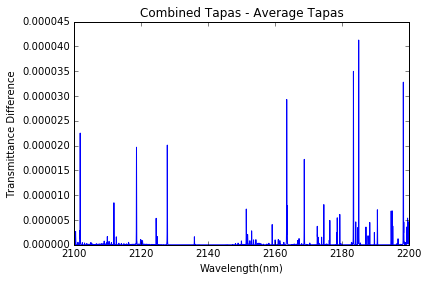

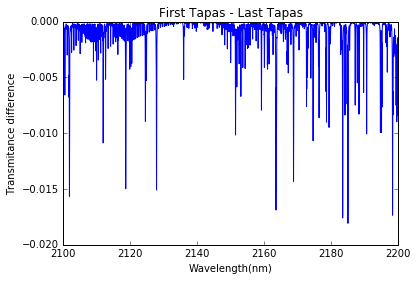

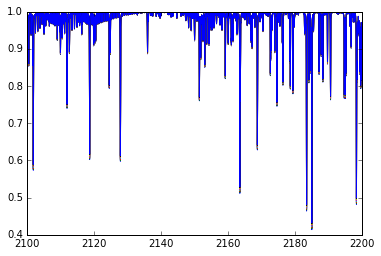

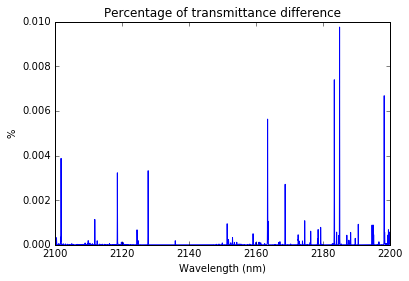

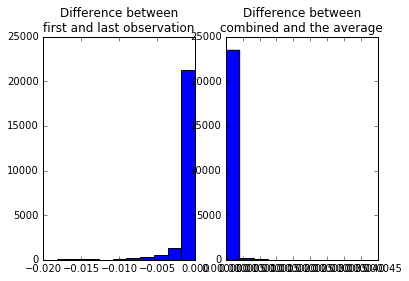

Maximum transmittance difference between combined and averaged 4.12793517942e-05
Maximum percentage change between combined and averaged = 0.009753741948265346 %
Maximum difference between first and last telluric spectra -3.75942010977e-05


In [11]:

HD30501_2b_files = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-2b/list_spectra.txt"
HD30501_2b_Path = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-2b/Raw_files/"
HD30501_2b_tapas = "/tapas_HD30501_2b_R50000_2012-08-06T09:56:00.ipac"

do_change_calculations(HD30501_2b_Path, HD30501_2b_files, HD30501_2b_tapas)

## HD30501-3

HD30501-1
Telluric Airmass  1.531332
Telluric Resolution Power = 50000

CRIRES Detector Intergration Time = 180.0
Nod_airmass  [1.593, 1.573, 1.5555, 1.537, 1.52, 1.5025, 1.4865, 1.4705]
Nod_time  ['08:47:30', '08:51:10', '08:54:39', '08:58:16', '09:01:45', '09:05:26', '09:08:55', '09:12:34']
Average airmass 1.52975


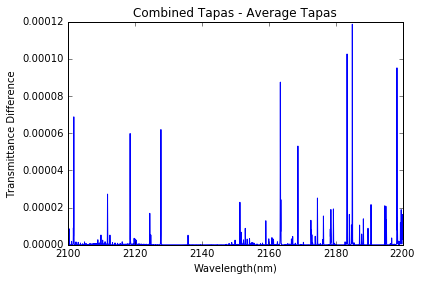

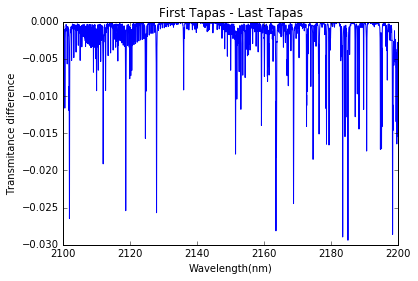

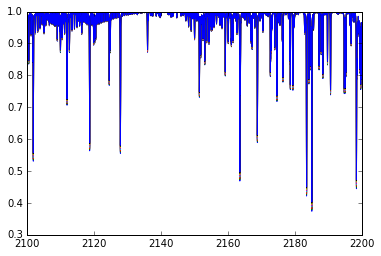

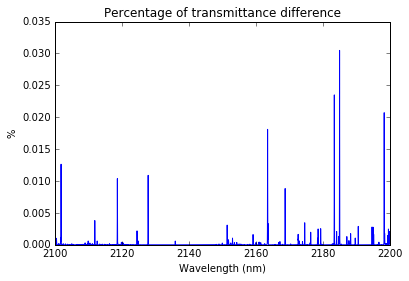

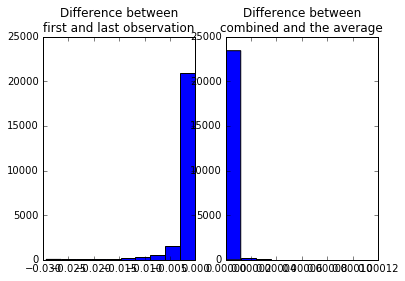

Maximum transmittance difference between combined and averaged 0.00011858181073
Maximum percentage change between combined and averaged = 0.030485539696725808 %
Maximum difference between first and last telluric spectra -7.15294295085e-05


In [12]:

HD30501_3_files = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-3/list_spectra.txt"
HD30501_3_Path = "/home/jneal/Phd/data/Crires/BDs-DRACS/HD30501-3/Raw_files/"
HD30501_3_tapas = "tapas_HD30501_3_R50000_2012-08-02T09:01:00.ipac"

do_change_calculations(HD30501_3_Path, HD30501_3_files, HD30501_3_tapas)